# Working with filing data from the SEC's EDGAR service

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
%matplotlib inline

from pathlib import Path
from datetime import date
import json
from io import BytesIO
from zipfile import ZipFile, BadZipFile
import requests

import pandas_datareader.data as web
import pandas as pd

from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import yfinance as yf

In [3]:
sns.set_style('whitegrid')

In [4]:
data_path = Path('data') # perhaps set to external harddrive to accomodate large amount of data
if not data_path.exists():
    data_path.mkdir()

## Download FS & Notes

The following code downloads and extracts all historical filings contained in the [Financial Statement and Notes](https://www.sec.gov/dera/data/financial-statement-and-notes-data-set.html) (FSN) datasets for the given range of quarters:

**Downloads over 40GB of data!**

In [5]:
SEC_URL = 'https://www.sec.gov/'
FSN_PATH = 'files/dera/data/financial-statement-and-notes-data-sets/'

In [6]:
today = pd.Timestamp(date.today())
this_year = today.year
this_quarter = today.quarter
# FRK: changed 2014 -> 2011
past_years = range(2010, 2011) # this_year)

In [7]:
filing_periods = [(y, q) for y in past_years for q in range(1, 5)]
filing_periods.extend([(this_year, q) for q in range(1, this_quarter + 1)])

In [8]:
# FRK: added cell to see what is stored in filing_periods
filing_periods

[(2010, 1), (2010, 2), (2010, 3), (2010, 4), (2021, 1), (2021, 2)]

In [ ]:
for i, (yr, qtr) in enumerate(filing_periods, 1):
    print(i, yr, qtr)
    
    print(f'{yr}-Q{qtr}', end=' ', flush=True)
    filing = f'{yr}q{qtr}_notes.zip'
    path = data_path / f'{yr}_{qtr}' / 'source'
    print(path)
    
    if not path.exists():
        path.mkdir(exist_ok=True, parents=True)
    # FRK: FSN -> FSN_PATH
    url = SEC_URL + FSN_PATH + filing
    
    # 2020q1 is currently (Oct 2020) in a different location; this may change at some point
    
    # FRK: commented this out as it does not seem to be needed. Did need to change year -> yr and
    # q -> qtr as well
#     if yr == 2020 and qtr == 1:
#         url = SEC_URL + 'files/node/add/data_distribution/' + filing
    
    # FRK: had to add url argument to get()
    response = requests.get(url).content
    
    try:
        with ZipFile(BytesIO(response)) as zip_file:
            for file in zip_file.namelist():
                local_file = path / file
                if local_file.exists():
                    continue
                with local_file.open('wb') as output:
                    for line in zip_file.open(file).readlines():
                        output.write(line)
    except BadZipFile:
        'https://www.sec.gov/files/node/add/data_distribution/2020q1_notes.zip'
        print('got bad zip file')
        continue

## Save to parquet

The data is fairly large and to enable faster access than the original text files permit, it is better to convert the text files to binary, columnar parquet format (see Section 'Efficient data storage with pandas' in chapter 2 for a performance comparison of various data-storage options compatible with pandas DataFrames):

In [9]:
# check what the for loop is doing. Added cell.
for f in sorted(data_path.glob('**/*.tsv')):
    print(f)

data/2010_1/source/cal.tsv
data/2010_1/source/dim.tsv
data/2010_1/source/num.tsv
data/2010_1/source/pre.tsv
data/2010_1/source/ren.tsv
data/2010_1/source/sub.tsv
data/2010_1/source/tag.tsv
data/2010_1/source/txt.tsv
data/2010_2/source/cal.tsv
data/2010_2/source/dim.tsv
data/2010_2/source/num.tsv
data/2010_2/source/pre.tsv
data/2010_2/source/ren.tsv
data/2010_2/source/sub.tsv
data/2010_2/source/tag.tsv
data/2010_2/source/txt.tsv
data/2010_3/source/cal.tsv
data/2010_3/source/dim.tsv
data/2010_3/source/num.tsv
data/2010_3/source/pre.tsv
data/2010_3/source/ren.tsv
data/2010_3/source/sub.tsv
data/2010_3/source/tag.tsv
data/2010_3/source/txt.tsv
data/2010_4/source/cal.tsv
data/2010_4/source/dim.tsv
data/2010_4/source/num.tsv
data/2010_4/source/pre.tsv
data/2010_4/source/ren.tsv
data/2010_4/source/sub.tsv
data/2010_4/source/tag.tsv
data/2010_4/source/txt.tsv


In [10]:
# FRK: added sorted() tot for loop
for f in sorted(data_path.glob('**/*.tsv')):
    file_name = f.stem  + '.parquet'
    path = Path(f.parents[1]) / 'parquet'
    if (path / file_name).exists():
        continue
    if not path.exists():
        path.mkdir(exist_ok=True)
    try:
        df = pd.read_csv(f, sep='\t', encoding='latin1', low_memory=False)
    except:
        print(f)
    df.to_parquet(path / file_name, engine='pyarrow' )

In [11]:
for f in sorted(data_path.glob('**/*.tsv')):
    print(f'rm {f}')

rm data/2010_1/source/cal.tsv
rm data/2010_1/source/dim.tsv
rm data/2010_1/source/num.tsv
rm data/2010_1/source/pre.tsv
rm data/2010_1/source/ren.tsv
rm data/2010_1/source/sub.tsv
rm data/2010_1/source/tag.tsv
rm data/2010_1/source/txt.tsv
rm data/2010_2/source/cal.tsv
rm data/2010_2/source/dim.tsv
rm data/2010_2/source/num.tsv
rm data/2010_2/source/pre.tsv
rm data/2010_2/source/ren.tsv
rm data/2010_2/source/sub.tsv
rm data/2010_2/source/tag.tsv
rm data/2010_2/source/txt.tsv
rm data/2010_3/source/cal.tsv
rm data/2010_3/source/dim.tsv
rm data/2010_3/source/num.tsv
rm data/2010_3/source/pre.tsv
rm data/2010_3/source/ren.tsv
rm data/2010_3/source/sub.tsv
rm data/2010_3/source/tag.tsv
rm data/2010_3/source/txt.tsv
rm data/2010_4/source/cal.tsv
rm data/2010_4/source/dim.tsv
rm data/2010_4/source/num.tsv
rm data/2010_4/source/pre.tsv
rm data/2010_4/source/ren.tsv
rm data/2010_4/source/sub.tsv
rm data/2010_4/source/tag.tsv
rm data/2010_4/source/txt.tsv


## Metadata json

In [12]:
file = data_path / '2020_3' / 'source' / '2020q3_notes-metadata.json'
with file.open() as f:
    data = json.load(f)

pprint(data)

{'@context': 'http://www.w3.org/ns/csvw',
 'dialect': {'delimiter': '\t', 'header': True, 'headerRowCount': 1},
 'tables': [{'tableSchema': {'aboutUrl': 'readme.htm',
                             'columns': [{'datatype': {'base': 'string',
                                                       'maxLength': 20,
                                                       'minLength': 20},
                                          'dc:description': 'Accession Number. '
                                                            'The 20-character '
                                                            'string formed '
                                                            'from the 18-digit '
                                                            'number assigned '
                                                            'by the Commission '
                                                            'to each EDGAR '
                                                           

                                                            'date.',
                                          'name': 'datp',
                                          'titles': ['Date Preference']},
                                         {'datatype': {'base': 'string',
                                                       'maxLength': 34},
                                          'dc:description': 'The 32-byte '
                                                            'hexadecimal key '
                                                            'for the '
                                                            'dimensional '
                                                            'information in '
                                                            'the DIM data set.',
                                          'name': 'dimh',
                                          'titles': ['Dimension Hash']},
                                         {'datatype': {'base': 

## Data Organization

For each quarter, the FSN data is organized into eight file sets that contain information about submissions, numbers, taxonomy tags, presentation, and more. Each dataset consists of rows and fields and is provided as a tab-delimited text file:

| File | Dataset      | Description                                                 |
|------|--------------|-------------------------------------------------------------|
| SUB  | Submission   | Identifies each XBRL submission by company, form, date, etc |
| TAG  | Tag          | Defines and explains each taxonomy tag                      |
| DIM  | Dimension    | Adds detail to numeric and plain text data                  |
| NUM  | Numeric      | One row for each distinct data point in filing              |
| TXT  | Plain Text   | Contains all non-numeric XBRL fields                        |
| REN  | Rendering    | Information for rendering on SEC website                    |
| PRE  | Presentation | Detail on tag and number presentation in primary statements |
| CAL  | Calculation  | Shows arithmetic relationships among tags                   |

## Submission Data

The latest submission file contains around 6,500 entries (2018, 3rd quarter).

In [13]:
sub1 = pd.read_parquet(data_path / '2018_3' / 'parquet' / 'sub.parquet')
sub1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 40 columns):
adsh           6493 non-null object
cik            6493 non-null int64
name           6493 non-null object
sic            6492 non-null float64
countryba      6482 non-null object
stprba         5900 non-null object
cityba         6482 non-null object
zipba          6478 non-null object
bas1           6482 non-null object
bas2           2804 non-null object
baph           6482 non-null object
countryma      6448 non-null object
stprma         5906 non-null object
cityma         6448 non-null object
zipma          6447 non-null object
mas1           6448 non-null object
mas2           2761 non-null object
countryinc     5936 non-null object
stprinc        5632 non-null object
ein            6492 non-null float64
former         3618 non-null object
changed        3618 non-null float64
afs            6480 non-null object
wksi           6493 non-null int64
fye            6490 non-null

In [14]:
sub2 = pd.read_parquet(data_path / '2020_4' / 'parquet' / 'sub.parquet')
sub2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16113 entries, 0 to 16112
Data columns (total 40 columns):
adsh           16113 non-null object
cik            16113 non-null int64
name           16113 non-null object
sic            16109 non-null float64
countryba      16086 non-null object
stprba         15162 non-null object
cityba         16086 non-null object
zipba          16077 non-null object
bas1           16086 non-null object
bas2           6684 non-null object
baph           16096 non-null object
countryma      16027 non-null object
stprma         15181 non-null object
cityma         16028 non-null object
zipma          16016 non-null object
mas1           16021 non-null object
mas2           6594 non-null object
countryinc     14696 non-null object
stprinc        13979 non-null object
ein            16110 non-null float64
former         9227 non-null object
changed        9227 non-null float64
afs            16048 non-null object
wksi           16113 non-null int64
fye   

### Get AAPL submission

The submission dataset contains the unique identifiers required to retrieve the filings: the Central Index Key (CIK) and the Accession Number (adsh). The following shows some of the information about Apple's 2018Q1 10-Q filing:

In [15]:
# FRK: for now point sub to sub2
sub = sub2
name = 'APPLE INC'
apple = sub[sub.name == name].T.dropna().squeeze()
key_cols = ['name', 'adsh', 'cik', 'name', 'sic', 'countryba', 'stprba',
            'cityba', 'zipba', 'bas1', 'form', 'period', 'fy', 'fp', 'filed']
apple.loc[key_cols]

,3645,4361
name,APPLE INC,APPLE INC
adsh,0000320193-20-000094,0000320193-20-000096
cik,320193,320193
name,APPLE INC,APPLE INC
sic,3571,3571
countryba,US,US
stprba,CA,CA
cityba,CUPERTINO,CUPERTINO
zipba,95014,95014
bas1,ONE APPLE PARK WAY,ONE APPLE PARK WAY


In [16]:
# FRK: play with sub dataframe. Note that it returns two rows. 
# The old notebook assumes it does return only one row.
# differences: adsh, form, period, filed, accepted, 
sub[sub.name=='APPLE INC'].T.dropna().squeeze()

,3645,4361
adsh,0000320193-20-000094,0000320193-20-000096
cik,320193,320193
name,APPLE INC,APPLE INC
sic,3571,3571
countryba,US,US
stprba,CA,CA
cityba,CUPERTINO,CUPERTINO
zipba,95014,95014
bas1,ONE APPLE PARK WAY,ONE APPLE PARK WAY
baph,(408) 996-1010,(408) 996-1010


## Build AAPL fundamentals dataset

Using the central index key, we can identify all historical quarterly filings available for Apple, and combine this information to obtain 26 Forms 10-Q and nine annual Forms 10-K.

### Get filings

In [17]:
apple.T.cik

3645    320193
4361    320193
Name: cik, dtype: object

In [18]:
apple.T.cik.unique()

array([320193], dtype=object)

In [19]:
sub.form

0           8-K
1           8-K
2          10-Q
3           8-K
4           8-K
          ...  
16108      10-Q
16109    10-Q/A
16110       S-1
16111       8-K
16112       8-K
Name: form, Length: 16113, dtype: object

In [20]:
sum(sub.cik.isin(list(apple.T.cik.unique())))

2

In [21]:
sum(sub.form.isin(['10-Q', '10-K']))

5752

In [22]:
aapl_subs = pd.DataFrame()
for sub in data_path.glob('**/sub.parquet'):
    sub = pd.read_parquet(sub)
    # FRK changed to (sub.cik.astype(int) == apple.cik) --> sub.cik.isin(list(apple.T.cik))
    # change needed as apple.cik can be multiple and hence we need to use apple.T.cik
    # code also works when apple only contains a series of scalars
    aapl_sub = sub[(sub.cik.isin(list(apple.T.cik.unique()))) & (sub.form.isin(['10-Q', '10-K']))]
    aapl_subs = pd.concat([aapl_subs, aapl_sub])

We find 30 quarterly 10-Q and 10 annual 10-K reports:

In [23]:
aapl_subs.form.value_counts()

10-Q    33
10-K    11
Name: form, dtype: int64

### Get numerical filing data

With the Accession Number for each filing, we can now rely on the taxonomies to select the appropriate XBRL tags (listed in the TAG file) from the NUM and TXT files to obtain the numerical or textual/footnote data points of interest.

First, let's extract all numerical data available from the 19 Apple filings:

In [24]:
aapl_subs

,adsh,cik,name,sic,countryba,stprba,cityba,zipba,bas1,bas2,...,accepted,prevrpt,detail,instance,nciks,aciks,pubfloatusd,floatdate,floataxis,floatmems
565,0001193125-15-023697,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,...,2015-01-28 16:40:00.0,0,1,aapl-20141227.xml,1,None,NaN,NaN,None,NaN
2032,0001628280-17-004790,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,...,2017-05-03 16:32:00.0,0,1,aapl-20170401.xml,1,None,NaN,NaN,None,NaN
1195,0000320193-19-000076,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE APPLE PARK WAY,None,...,2019-07-31 16:32:00.0,0,1,a10-qq320196292019_htm.xml,1,None,NaN,NaN,NaN,NaN
3210,0000320193-19-000119,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE APPLE PARK WAY,None,...,2019-10-30 18:13:00.0,0,1,a10-k20199282019_htm.xml,1,None,8.746980e+11,20190329.0,None,NaN
708,0001193125-13-300670,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,...,2013-07-24 17:02:00.0,0,1,aapl-20130629.xml,1,None,NaN,NaN,None,NaN
1158,0001193125-13-416534,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,...,2013-10-29 20:38:00.0,0,1,aapl-20130928.xml,1,None,4.160050e+11,20130329.0,None,NaN
1197,0000320193-17-000009,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,...,2017-08-02 16:31:00.0,0,1,aapl-20170701.xml,1,None,NaN,NaN,None,NaN
1821,0000320193-17-000070,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,...,2017-11-03 08:02:00.0,0,1,aapl-20170930.xml,1,None,7.475090e+11,20170331.0,None,NaN
1743,0001193125-13-168288,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,...,2013-04-23 21:29:00.0,0,1,aapl-20130330.xml,1,None,NaN,NaN,None,NaN
44,0001193125-11-010144,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,...,2011-01-19 16:33:00.0,0,1,aapl-20101225.xml,1,None,NaN,NaN,None,NaN


In [25]:
aapl_subs.adsh

565     0001193125-15-023697
2032    0001628280-17-004790
1195    0000320193-19-000076
3210    0000320193-19-000119
708     0001193125-13-300670
1158    0001193125-13-416534
1197    0000320193-17-000009
1821    0000320193-17-000070
1743    0001193125-13-168288
44      0001193125-11-010144
1909    0000320193-19-000066
1934    0000320193-20-000010
27      0001193125-10-162840
167     0001193125-10-238044
481     0001193125-16-439878
1281    0001193125-14-157311
610     0000320193-18-000007
16      0001193125-10-088957
504     0001193125-12-023398
582     0001193125-14-277160
775     0001193125-14-383437
521     0001193125-11-282113
63      0001193125-11-192493
1356    0001193125-15-153166
590     0001628280-17-000717
563     0001193125-13-022339
86      0001193125-11-104388
373     0000320193-19-000010
796     0001193125-15-356351
515     0001193125-15-259935
4165    0000320193-20-000062
4361    0000320193-20-000096
4205    0000320193-20-000052
1154    0001193125-16-559625
661     000119

In [26]:
aapl_nums = pd.DataFrame()
for num in data_path.glob('**/num.parquet'):
    num = pd.read_parquet(num).drop('dimh', axis=1)
    aapl_num = num[num.adsh.isin(aapl_subs.adsh)]
    print(len(aapl_num))
    aapl_nums = pd.concat([aapl_nums, aapl_num])
aapl_nums.ddate = pd.to_datetime(aapl_nums.ddate, format='%Y%m%d')   
aapl_nums.to_parquet(data_path / 'aapl_nums.parquet')


# FRK: added to see total # of rows in aapl_nums
print(f"Total rows in aapl_nums: {len(aapl_nums)}")

751
951
1039
1176
767
1151
1001
1364
703
602
1035
784
859
1291
707
805
793
176
525
919
1271
1068
669
942
738
557
644
755
1345
961
1028
1223
1017
905
682
1032
645
1224
937
1277
923
952
145
647
Total rows in aapl_nums: 38986


In [28]:
aapl_nums.columns

Index(['adsh', 'tag', 'version', 'ddate', 'qtrs', 'uom', 'iprx', 'value',
       'footnote', 'footlen', 'dimn', 'coreg', 'durp', 'datp', 'dcml'],
      dtype='object')

In [29]:
# FRK: added to see how many unique tags there are
len(aapl_nums.tag.unique())

780

In [287]:
# FRK: Added to see the tages that contain 'Shares' in their tag name
for t in sorted(aapl_nums.tag.unique()):
    if 'Shares' in t:
        print(t)

AdditionalStockRepurchasedAndRetiredDuringPeriodShares
CommonStockSharesAuthorized
CommonStockSharesIssued
CommonStockSharesOutstanding
CumulativeStockRepurchasedAndRetiredShares
EntityCommonStockSharesOutstanding
EquityInstrumentsOtherThanOptionsSharesNetShareSettledToCoverWithholdingTaxes
FactorByWhichEachRSUGrantedReducesAndEachRSUCanceledOrShareWithheldForTaxesIncreasesSharesAvailableForGrant
FactorByWhichEachRSUGrantedReducesOrEachRSUCanceledOrShareWithheldForTaxesIncreasesSharesAvailableForGrant
PreferredStockSharesAuthorized
RemainingStockRepurchasedAndRetiredDuringSubsequentPeriodShares
Share-BasedCompensationArrangementByShareBasedPaymentAwardOptionsAvailableForGrantAdditionalSharesAuthorizedInPeriod
ShareBasedCompensationArrangementByEmployeeStockPurchasePlanNumberOfSharesAuthorized
ShareBasedCompensationArrangementByShareBasedPaymentAwardEquityInstrumentsOtherThanOptionsNumberOfSharesOfCommonStockIssuedPerUnitUponVesting
ShareBasedCompensationArrangementByShareBasedPaymentAw

In total, the nine years of filing history provide us with over 18,000 numerical values for AAPL. This comment is based upon 2014, 1st qtr - 2018, 1st qtr. It now goes up to 2020, 4th qtr. It has over 27,000 rows now.

In [31]:
aapl_nums.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38986 entries, 4298 to 3245154
Data columns (total 15 columns):
adsh        38986 non-null object
tag         38986 non-null object
version     38986 non-null object
ddate       38986 non-null datetime64[ns]
qtrs        38986 non-null int64
uom         38986 non-null object
iprx        38986 non-null float64
value       38880 non-null float64
footnote    189 non-null object
footlen     38986 non-null int64
dimn        38986 non-null int64
coreg       0 non-null object
durp        38986 non-null float64
datp        38986 non-null float64
dcml        38986 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3), object(6)
memory usage: 4.8+ MB


## Create P/E Ratio from EPS and stock price data

We can select a useful field, such as Earnings per Diluted Share (EPS), that we can combine with market data to calculate the popular Price/Earnings (P/E) valuation ratio.

In [32]:
# stock_split = 7
# split_date = pd.to_datetime('20140604')
# split_date

We do need to take into account, however, that Apple split its stock 7:1 on June 4, 2014, and Adjusted Earnings per Share before the split to make earnings comparable, as illustrated in the following code block:

In [33]:
# FRK: added to understand different quarter values better
aapl_nums[(aapl_nums.tag == 'EarningsPerShareDiluted')].qtrs.value_counts()

1    164
4     39
3     26
2     26
Name: qtrs, dtype: int64

In [35]:
aapl_nums[(aapl_nums.tag == 'EarningsPerShareDiluted') & (aapl_nums.qtrs == 1)].drop('tag', axis=1)

,adsh,version,ddate,qtrs,uom,iprx,value,footnote,footlen,dimn,coreg,durp,datp,dcml
627739,0001193125-15-023697,us-gaap/2014,2013-12-31,1,USD,0.0,2.07,None,0,0,None,0.013699,3.0,2.0
627740,0001193125-15-023697,us-gaap/2014,2014-12-31,1,USD,0.0,3.06,None,0,0,None,0.013699,4.0,2.0
1114990,0001628280-17-004790,us-gaap/2016,2016-03-31,1,USD,0.0,1.90,None,0,0,None,0.013699,5.0,2.0
1114992,0001628280-17-004790,us-gaap/2016,2017-03-31,1,USD,0.0,2.10,None,0,0,None,0.013699,-1.0,2.0
1029851,0000320193-19-000076,us-gaap/2018,2019-06-30,1,USD,1.0,2.18,None,0,0,None,0.013699,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010648,0000320193-18-000070,us-gaap/2017,2018-03-31,1,USD,0.0,2.73,None,0,0,None,0.013699,0.0,2.0
41627,0001193125-10-012085,us-gaap/2009,2008-12-31,1,USD,0.0,2.50,None,0,0,None,0.013699,4.0,2.0
41628,0001193125-10-012085,us-gaap/2009,2009-12-31,1,USD,0.0,3.67,None,0,0,None,0.013699,5.0,2.0
864165,0001193125-12-182321,us-gaap/2012,2011-03-31,1,USD,0.0,6.40,None,0,0,None,0.013699,5.0,2.0


In [ ]:
# FRK: make sure I understand what the drop() is doing. It basically drops the tag column as that is no 
# longer needed
eps = aapl_nums[(aapl_nums.tag == 'EarningsPerShareDiluted') & (aapl_nums.qtrs == 1)].drop('tag', axis=1)
eps = eps[['adsh', 'ddate', 'value']].groupby('adsh').apply(lambda x: x.nlargest(n=1, columns=['ddate']))
eps.index = eps.ddate.values
eps = eps[['ddate', 'value']]
eps = eps.sort_values(by='ddate', ascending=True)
eps, len(eps)

In [ ]:
# # Filter by tag; keep only values measuring 1 quarter
# eps = aapl_nums[(aapl_nums.tag == 'EarningsPerShareDiluted')
#                 & (aapl_nums.qtrs == 1)].drop('tag', axis=1)

# # Keep only most recent data point from each filing
# eps = eps.groupby('adsh').apply(lambda x: x.nlargest(n=1, columns=['ddate']))

# # Adjust earnings prior to stock split downward
# # FRK: change div(7) -> div(stock_split)
# # eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(stock_split)
# # eps = eps[['ddate', 'value']].set_index('ddate').squeeze().sort_index()
# # eps = eps.rolling(4,min_periods=4).sum().dropna()

In [ ]:
# eps['value'].plot(lw=2, figsize=(14, 6), title='Diluted Earnings per Share')
# plt.xlabel('')
# plt.savefig('diluted eps', dps=300);

In [ ]:
symbol = 'AAPL'
import yfinance as yf
aapl_stock =yf.Ticker(symbol).history(start=str(eps.index.min())[:10], end=str(eps.index.max())[:10])
aapl_stock.info()

In [ ]:
aapl_stock['Stock Splits'].value_counts()

In [ ]:
splits = aapl_stock[['Stock Splits']].loc[aapl_stock['Stock Splits'] > 0]
splits['Split_Date'] = splits.index.values
splits

In [ ]:
# eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(stock_split)
# eps = eps[['ddate', 'value']].set_index('ddate').squeeze().sort_index()
# eps = eps.rolling(4,min_periods=4).sum().dropna()

In [ ]:
splits = aapl_stock[['Stock Splits']].loc[aapl_stock['Stock Splits'] > 0]
splits['Split_Date'] = splits.index
# splits
for index, row in splits.sort_values(by='Split_Date', ascending=False).iterrows():
    split_date        = str(index)[:10]
    stock_split = row['Stock Splits']
    print(split_date, stock_split)
    eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(stock_split)

eps = eps[['ddate', 'value']].set_index('ddate').squeeze().sort_index()
eps = eps.rolling(4,min_periods=4).sum().dropna()
eps

In [ ]:
aapl_stock.Close.to_frame('price')

In [ ]:
pe = aapl_stock.Close.to_frame('price').join(eps.to_frame('eps'))
pe

In [ ]:
pe = pe.fillna(method='ffill').dropna()
pe

In [ ]:
pe['P/E Ratio'] = pe.price.div(pe.eps)
pe #['P/E Ratio']

In [ ]:
pe['P/E Ratio'].plot(lw=2, figsize=(14, 6), title='TTM P/E Ratio');

In [ ]:
# pe = aapl_stock.Close.to_frame('price').join(eps.to_frame('eps'))
# pe = pe.fillna(method='ffill').dropna()
# pe['P/E Ratio'] = pe.price.div(pe.eps)
# pe['P/E Ratio'].plot(lw=2, figsize=(14, 6), title='TTM P/E Ratio');

In [ ]:
pe.info()

In [ ]:
axes = pe.plot(subplots=True, figsize=(16,8), legend=False, lw=2)
axes[0].set_title('Adj. Close Price')
axes[1].set_title('Diluted Earnings per Share')
axes[2].set_title('Trailing P/E Ratio')
plt.tight_layout();

## Explore Additional Fields

The field `tag` references values defined in the taxonomy:

In [ ]:
aapl_nums.tag.value_counts()

We can select values of interest and track their value or use them as inputs to compute fundamental metrics like the Dividend/Share ratio.

### Dividends per Share

In [ ]:
fields = ['EarningsPerShareDiluted',
          'PaymentsOfDividendsCommonStock',
          'WeightedAverageNumberOfDilutedSharesOutstanding',
          'OperatingIncomeLoss',
          'NetIncomeLoss',
          'GrossProfit']

In [ ]:
dividends = (aapl_nums
             .loc[aapl_nums.tag == 'PaymentsOfDividendsCommonStock', ['ddate', 'value']]
             .groupby('ddate')
             .mean())
shares = (aapl_nums
          .loc[aapl_nums.tag == 'WeightedAverageNumberOfDilutedSharesOutstanding', ['ddate', 'value']]
          .drop_duplicates()
          .groupby('ddate')
          .mean())
df = dividends.div(shares).dropna()
ax = df.plot.bar(figsize=(14, 5), title='Dividends per Share', legend=False)
ax.xaxis.set_major_formatter(mticker.FixedFormatter(df.index.strftime('%Y-%m')))

## Bonus: Textual Information

In [ ]:
txt = pd.read_parquet(data_path / '2016_2' / 'parquet' /  'txt.parquet')

AAPL's adsh is not avaialble in the txt file but you can obtain notes from the financial statesments here:

In [ ]:
txt.head()

## Given Company Name Retrieve the P/E Series

In [ ]:
name   = 'ORACLE CORP'
ticker = 'ORCL'

In [ ]:
# Get corporation info
corp = sub[sub.name == name].T.dropna().squeeze()
key_cols = ['name', 'adsh', 'cik', 'name', 'sic', 'countryba', 'stprba',
            'cityba', 'zipba', 'bas1', 'form', 'period', 'fy', 'fp', 'filed']
corp.loc[key_cols]

In [ ]:
corp.T.cik

In [ ]:
type(corp.T.cik)

In [ ]:
corp_subs = pd.DataFrame()
cik = corp.T.cik

if type(cik) is int:
    cik_l = [ cik ]
else:
    cik_l = list(corp.T.cik.unique())
    
for sub in data_path.glob('**/sub.parquet'):
    sub = pd.read_parquet(sub)
    idx = (sub.cik.isin(cik_l)) & (sub.form.isin(['10-Q', '10-K']))
    corp_sub = sub.loc[idx]
    corp_subs = pd.concat([corp_subs, corp_sub])

In [ ]:
corp_subs

In [ ]:
corp_nums = pd.DataFrame()

for num in data_path.glob('**/num.parquet'):
    num = pd.read_parquet(num).drop('dimh', axis=1)
    corp_num = num[num.adsh.isin(corp_subs.adsh)]
    corp_nums = pd.concat([corp_nums, corp_num])

corp_nums.ddate = pd.to_datetime(corp_nums.ddate, format='%Y%m%d')   
corp_nums.to_parquet(data_path / f'{ticker}_nums.parquet')


# FRK: added to see total # of rows in aapl_nums
print(f"Total rows in corp_nums: {len(corp_nums)}")

In [ ]:
corp_nums.info()

In [ ]:
type(corp_nums)

In [ ]:
idx = (corp_nums.tag == 'EarningsPerShareDiluted') & (corp_nums.qtrs == 1)
eps = corp_nums.loc[idx].drop('tag', axis=1)

eps = eps[['adsh', 'ddate', 'value']].groupby('adsh').apply(lambda x: x.nlargest(n=1, columns=['ddate']))
eps.index = eps.ddate.values
eps = eps[['ddate', 'value']]
eps = eps.sort_values(by='ddate', ascending=True)
eps, len(eps)

In [ ]:
symbol = ticker
import yfinance as yf
corp_stock =yf.Ticker(ticker).history(start=str(eps.index.min())[:10], end=str(eps.index.max())[:10])
corp_stock.info()

In [ ]:
splits = corp_stock[['Stock Splits']].loc[corp_stock['Stock Splits'] > 0]
splits['Split_Date'] = splits.index

for index, row in splits.sort_values(by='Split_Date', ascending=False).iterrows():
    split_date  = str(index)[:10]
    stock_split = row['Stock Splits']
    print(split_date, stock_split)
    eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(stock_split)

eps = eps[['ddate', 'value']].set_index('ddate').squeeze().sort_index()
eps = eps.rolling(4,min_periods=4).sum().dropna()
eps

In [ ]:
(len(eps))

In [ ]:
splits

In [ ]:
pe = corp_stock.Close.to_frame('price').join(eps.to_frame('eps'))
pe

In [ ]:
pe = pe.fillna(method='ffill').dropna()
pe

In [ ]:
pe['P/E Ratio'] = pe.price.div(pe.eps)

In [ ]:
pe

In [ ]:
pe['P/E Ratio'].plot(lw=2, figsize=(14, 6), title='TTM P/E Ratio');

In [ ]:
axes = pe.plot(subplots=True, figsize=(16,8), legend=False, lw=2)
axes[0].set_title('Adj. Close Price')
axes[1].set_title('Diluted Earnings per Share')
axes[2].set_title('Trailing P/E Ratio')
plt.tight_layout();

In [ ]:
corp_stock[corp_stock['Dividends'] > 0].join(pe)

In [46]:
def get_pe(name, ticker):
    
    sub = pd.read_parquet(data_path / '2020_4' / 'parquet' / 'sub.parquet')
    corp = sub[sub.name == name].T.dropna().squeeze()

    # Get details on the forms
    corp_subs = pd.DataFrame()
    cik = corp.T.cik

    if type(cik) is int:
        cik_l = [ cik ]
    else:
        cik_l = list(corp.T.cik.unique())

    for sub in data_path.glob('**/sub.parquet'):
        sub = pd.read_parquet(sub)
        idx = (sub.cik.isin(cik_l)) & (sub.form.isin(['10-Q', '10-K']))
        corp_sub = sub.loc[idx]
        corp_subs = pd.concat([corp_subs, corp_sub])
    
    assert len(corp_subs) > 0, "No data found in SUB for {name} {ticker}!"
    
    # Get numeric details on the forms
    nums_file = data_path / f'{ticker}_nums.parquet'
    if nums_file.exists():
        corp_nums = pd.read_parquet(data_path / f'{ticker}_nums.parquet')
    else:
        print("File not available, will process the individual num files instead")
    
        corp_nums = pd.DataFrame()
        for num in data_path.glob('**/num.parquet'):
            num = pd.read_parquet(num).drop('dimh', axis=1)
            corp_num = num[num.adsh.isin(corp_subs.adsh)]
            corp_nums = pd.concat([corp_nums, corp_num])

        assert len(corp_nums) != 0, "No rows in corp_nums!"
        corp_nums.ddate = pd.to_datetime(corp_nums.ddate, format='%Y%m%d')   
        corp_nums.to_parquet(data_path / f'{ticker}_nums.parquet')
    
    # Retrieve the Earnings per share diluted
    # It only keeps the latest reported earnings.
    # Needs be refined over time as it is leaking information here.
    idx = (corp_nums.tag == 'EarningsPerShareDiluted') & (corp_nums.qtrs == 1)
    eps = corp_nums.loc[idx].drop('tag', axis=1)
    print(eps.columns)
    eps = eps[['adsh', 'ddate', 'value']].groupby('adsh').apply(lambda x: x.nlargest(n=1, columns=['ddate']))
    eps.index = eps.ddate.values
    eps = eps[['ddate', 'value']]
    eps = eps.sort_values(by='ddate', ascending=True)
    

    # Get stock data and process splits and adjust reported earnings
    corp_stock =yf.Ticker(ticker).history(start=str(eps.index.min())[:10], end=str(eps.index.max())[:10])
    assert len(corp_stock) > 0, "yfinance did not return any rows!"
    splits = corp_stock[['Stock Splits']].loc[corp_stock['Stock Splits'] > 0]
    splits['Split_Date'] = splits.index

    for index, row in splits.sort_values(by='Split_Date', ascending=False).iterrows():
        split_date  = str(index)[:10]
        stock_split = row['Stock Splits']
        print(split_date, stock_split)
        eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(stock_split)

    eps = eps[['ddate', 'value']].set_index('ddate').squeeze().sort_index()
    eps = eps.rolling(window=4).sum()#.dropna()
    
    # Calculate p/e ratio
    pe = corp_stock.Close.to_frame('price').join(eps.to_frame('eps'))
    pe = pe.fillna(method='ffill')#.dropna()
    pe['P/E Ratio'] = pe.price.div(pe.eps)
    return pe

In [ ]:
%%time
name   = 'ORACLE CORP'
ticker = 'ORCL'
pe = get_pe(name, ticker)
pe

In [ ]:
!date

In [ ]:
axes = pe.plot(subplots=True, figsize=(16,8), legend=False, lw=2)
axes[0].set_title('Adj. Close Price')
axes[1].set_title('Diluted Earnings per Share')
axes[2].set_title('Trailing P/E Ratio')
plt.tight_layout();

In [50]:
ticker = 'ADBE'
name   = 'ADOBE INC.'
pe = get_pe(name, ticker)
pe

Index(['adsh', 'version', 'ddate', 'qtrs', 'uom', 'iprx', 'value', 'footnote',
       'footlen', 'dimn', 'coreg', 'durp', 'datp', 'dcml'],
      dtype='object')


,price,eps,P/E Ratio
Date,,,
2010-03-01,34.89,NaN,NaN
2010-03-02,34.74,NaN,NaN
2010-03-03,34.82,NaN,NaN
2010-03-04,34.94,NaN,NaN
2010-03-05,35.16,NaN,NaN
...,...,...,...
2020-08-24,476.30,5.36,88.861940
2020-08-25,484.43,5.36,90.378731
2020-08-26,528.49,5.36,98.598881


In [51]:
corp_nums = pd.read_parquet(data_path / f'{ticker}_nums.parquet')
corp_nums

,adsh,tag,version,ddate,qtrs,uom,iprx,value,footnote,footlen,dimn,coreg,durp,datp,dcml
3543137,0000796343-15-000084,AccountsPayableCurrent,us-gaap/2014,2014-11-30,0,USD,0.0,68377000.0,None,0,0,None,0.0,2.0,-3.0
3543138,0000796343-15-000084,AccountsPayableCurrent,us-gaap/2014,2015-02-28,0,USD,0.0,71670000.0,None,0,0,None,0.0,1.0,-3.0
3545516,0000796343-15-000022,AccountsPayableCurrent,us-gaap/2014,2013-11-30,0,USD,0.0,62096000.0,None,0,0,None,0.0,1.0,-3.0
3545517,0000796343-15-000022,AccountsPayableCurrent,us-gaap/2014,2014-11-30,0,USD,0.0,68377000.0,None,0,0,None,0.0,2.0,-3.0
3547800,0000796343-15-000084,AccountsReceivableNetCurrent,us-gaap/2014,2014-11-30,0,USD,0.0,591800000.0,None,0,0,None,0.0,2.0,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3144442,0000796343-12-000022,VestedAndExpectedToVestIntrinsicValue,0000796343-12-000022,2011-05-31,0,USD,0.0,502700000.0,None,0,1,None,0.0,-3.0,-5.0
3144443,0000796343-12-000022,VestedAndExpectedToVestShares,0000796343-12-000022,2012-05-31,0,shares,0.0,394000.0,None,0,2,None,0.0,-1.0,-3.0
3144444,0000796343-12-000022,VestedAndExpectedToVestShares,0000796343-12-000022,2011-05-31,0,shares,0.0,421000.0,None,0,2,None,0.0,-3.0,-3.0
3144445,0000796343-12-000022,VestedAndExpectedToVestShares,0000796343-12-000022,2011-05-31,0,shares,0.0,15128000.0,None,0,1,None,0.0,-3.0,-3.0


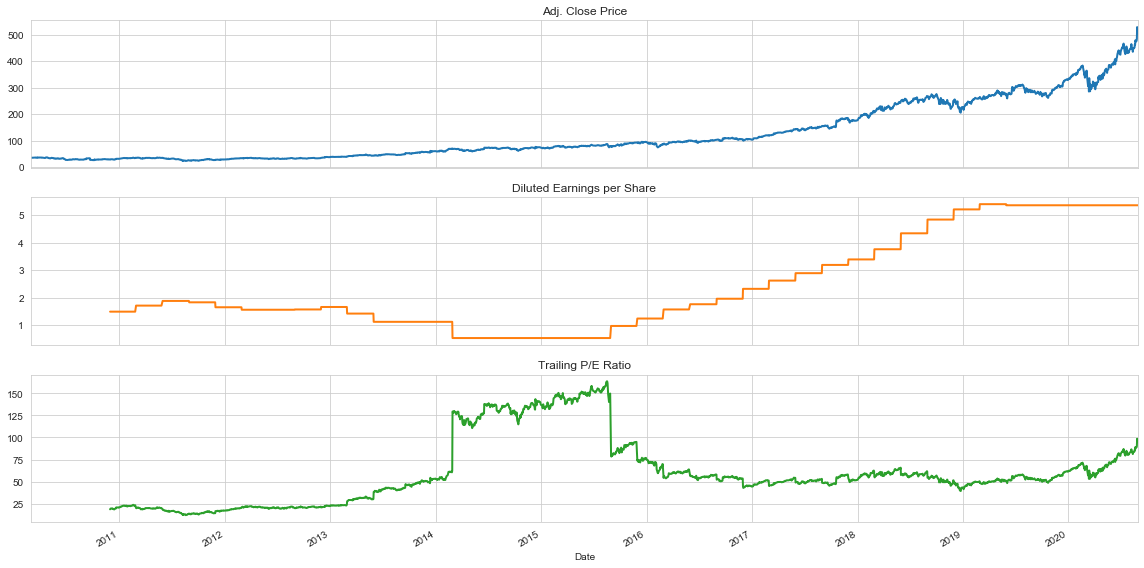

In [52]:
axes = pe.plot(subplots=True, figsize=(16,8), legend=False, lw=2)
axes[0].set_title('Adj. Close Price')
axes[1].set_title('Diluted Earnings per Share')
axes[2].set_title('Trailing P/E Ratio')
plt.tight_layout();

In [56]:
len(sub.name.unique())

7709

In [67]:
names_set = set(sub.name)

In [63]:
stocks = pd.read_csv('stocks202002.csv') 
stocks

,NAME_OF_ISSUER,CUSIP,TICKER,RT,BLK
0,1347 PPTY INS HLDGS INC,68244P107,PIH,1,1
1,1ST CONSTITUTION BANCORP,31986N102,FCCY,1,1
2,1ST SOURCE CORP,336901103,SRCE,1,1
3,A10 NETWORKS INC,002121101,ATEN,1,1
4,AAR CORP,000361105,AIR,1,1
...,...,...,...,...,...
2791,ENVELA CORPORATION,29402E102,ELA,1,0
2792,DAVIDSTEA INC,238661102,DTEA,1,0
2793,GENIUS BRANDS INTL INC,37229T301,GNUS,1,0
2794,DELMAR PHARMACEUTICALS INC,247078306,DMPI,1,0


In [88]:
count_in = 0
orig_l = []
found_l = []
not_found_l = []
for index, row in stocks.iterrows():
    corp_name = str(row['NAME_OF_ISSUER'])
    orig_name = corp_name
    if corp_name in names_set:
        count_in += 1
        orig_l.append(orig_name)
        found_l.append(corp_name)
        continue
    
    if corp_name[-1] in ['.']:
        not_found_l.append(corp_name)
        continue
        
    if corp_name in names_set:
        count_in += 1
        orig_l.append(orig_name)
        found_l.append(corp_name)
        continue        
        
    corp_name = corp_name + '.'
    if corp_name in names_set:
        count_in += 1
        orig_l.append(orig_name)
        found_l.append(corp_name)
        continue
    
    corp_name = corp_name[:-1]
    not_found_l.append(corp_name)
    
print(f"Found {count_in} out of {len(stocks)}")

Found 644 out of 2796


In [79]:
found_l

['1ST CONSTITUTION BANCORP',
 '1ST SOURCE CORP',
 'ABIOMED INC',
 'ACADIA PHARMACEUTICALS INC',
 'ACCO BRANDS CORP',
 'ACCURAY INC',
 'ACNB CORP',
 'ACORDA THERAPEUTICS INC',
 'ACUITY BRANDS INC',
 'ADTRAN INC',
 'ADVANCED MICRO DEVICES INC',
 'AEGION CORP',
 'AEROCENTURY CORP',
 'AEROVIRONMENT INC',
 'AES CORP',
 'AGILENT TECHNOLOGIES INC',
 'AGILYSYS INC',
 'AGNICO EAGLE MINES LTD',
 'AIRCASTLE LTD',
 'AIR T INC',
 'AKAMAI TECHNOLOGIES INC',
 'AKORN INC',
 'ALASKA AIR GROUP INC',
 'ALEXANDERS INC',
 'ALEXION PHARMACEUTICALS INC',
 'ALICO INC',
 'ALIGN TECHNOLOGY INC',
 'ALLEGIANT TRAVEL CO',
 'ALLIANT ENERGY CORP',
 'ALLSTATE CORP',
 'ALPHA PRO TECH LTD',
 'AMAG PHARMACEUTICALS INC.',
 'AMEDISYS INC',
 'AMEREN CORP',
 'AMERICAN EXPRESS CO',
 'AMERICAN RIVER BANKSHARES',
 'AMERICAN VANGUARD CORP',
 'AMERISAFE INC',
 'AMGEN INC',
 'AMICUS THERAPEUTICS INC',
 'AMKOR TECHNOLOGY INC',
 'ANDERSONS INC',
 'ANGIODYNAMICS INC',
 'ANIKA THERAPEUTICS INC',
 'APPLE INC',
 'ARGAN INC',
 'ARK REST

In [80]:
len(orig_l)

644

In [84]:
name_map = {}
for orig_n, n in zip(orig_l,found_l):
    name_map[orig_n] = n

In [85]:
len(name_map)

644

In [185]:
not_found_l[50:60]

['AMERICAN EAGLE OUTFITTERS IN',
 'AMERICAN ELEC PWR CO INC',
 'AMERICAN EQTY INVT LIFE HLD',
 'AMERICAN FINL GROUP INC OHIO',
 'AMERICAN NATL BANKSHARES INC',
 'AMERICAN NATL INS CO',
 'AMERICAN OUTDOOR BRANDS CORP',
 'AMERICAN PUBLIC EDUCATION IN',
 'AMERICAN RENAL ASSOCIATES HO',
 'AMERICAN RLTY INVS INC']

In [184]:
stocks.loc[stocks.NAME_OF_ISSUER == 'A MARK PRECIOUS METALS INC']

,NAME_OF_ISSUER,CUSIP,TICKER,RT,BLK
80,A MARK PRECIOUS METALS INC,00181T107,AMRK,1,1


In [201]:
for n in names_set:
    if 'AMERICAN' in n and 'REAL' in n :
        print(n)

AMERICAN REALTY FUNDS CORP
AMERICAN REALTY CAPITAL DAILY NET ASSET VALUE TRUST, INC.
AMERICAN SPECTRUM REALTY INC
INLAND AMERICAN REAL ESTATE TRUST, INC.
AMERICAN REALTY CAPITAL NEW YORK RECOVERY REIT INC
AMERICAN REALTY CAPITAL - RETAIL CENTERS OF AMERICA, INC.
AMERICAN REALTY CAPITAL TRUST, INC.
AMERICAN REALTY CAPITAL GLOBAL DAILY NET ASSET VALUE TRUST, INC.
AMERICAN REALTY CAPITAL TRUST III, INC.
AMERICAN REALTY CAPITAL HEALTHCARE TRUST INC
AMERICAN REALTY CAPITAL PROPERTIES, INC.
AMERICAN REALTY INVESTORS INC


In [202]:
name_map['ABRAXAS PETE CORP'] = 'ABRAXAS PETROLEUM CORP'
name_map['ABM INDS INC'] = 'ABM INDUSTRIES INC /DE/'
name_map['ACME UTD CORP'] = 'ACME UNITED CORP'
name_map['ADOBE INC'] = 'ADOBE SYSTEMS INC'
name_map['ADVANCED ENERGY INDS'] = 'ADVANCED ENERGY INDUSTRIES INC'
name_map['AFFILIATED MANAGERS GROUP IN'] = 'AFFILIATED MANAGERS GROUP INC'
name_map['AGCO CORP'] = 'AGCO CORP /DE'
name_map['ALASKA COMMUNICATIONS SYS GR'] = 'ALASKA COMMUNICATIONS SYSTEMS GROUP INC'
name_map['ALCOA CORP'] = 'ALCOA INC'
name_map['ALLEGHANY CORP DEL'] = 'ALLEGHANY CORP /DE'
name_map['ALLIED MOTION TECHNOLOGIES I'] = 'ALLIED MOTION TECHNOLOGIES INC'
name_map['ALLISON TRANSMISSION HLDGS I'] = 'ALLISON TRANSMISSION HOLDINGS INC'
name_map['ALLY FINL INC'] = 'ALLY FINANCIAL INC.'
name_map['ALTRIA GROUP INC'] = 'ALTRIA GROUP, INC.'
name_map['AMERICAN CAMPUS CMNTYS INC'] = 'AMERICAN CAMPUS COMMUNITIES INC'
name_map['AMERICAN EAGLE OUTFITTERS IN'] = 'AMERICAN EAGLE OUTFITTERS INC'
name_map['AMERICAN ELEC PWR CO INC'] = 'AMERICAN ELECTRIC POWER CO INC'
name_map['AMERICAN EQTY INVT LIFE HLD'] = 'AMERICAN EQUITY INVESTMENT LIFE HOLDING CO'
name_map['AMERICAN FINL GROUP INC OHIO'] = 'AMERICAN FINANCIAL GROUP INC'
name_map['AMERICAN NATL BANKSHARES INC'] = 'AMERICAN NATIONAL BANKSHARES INC'
name_map['AMERICAN NATL INS CO'] = 'AMERICAN NATIONAL INSURANCE CO /TX/'
name_map['AMERICAN PUBLIC EDUCATION IN'] = 'AMERICAN PUBLIC EDUCATION INC'
name_map['AMERICAN RENAL ASSOCIATES HO'] = 'AMERICAN RENAL ASSOCIATES HOLDINGS, INC.'
name_map['AMERICAN RLTY INVS INC'] = 'AMERICAN REALTY INVESTORS INC'
len(name_map)

668

In [203]:
count_in = 0

for index, row in stocks.iterrows():
    orig_name = str(row['NAME_OF_ISSUER'])
    if orig_name not in name_map:
        continue
    corp_name = name_map[orig_name]
    if corp_name in names_set:
        count_in += 1
    
print(f"Found {count_in} out of {len(stocks)}")

Found 668 out of 2796


In [215]:
# Changes from above:
# - Renamed the directory structure where nums file is saved and read from

def get_pe(name, ticker):
    
    sub = pd.read_parquet(data_path / '2020_4' / 'parquet' / 'sub.parquet')
    corp = sub[sub.name == name].T.dropna().squeeze()

    # Get details on the forms
    corp_subs = pd.DataFrame()
    cik = corp.T.cik

    if type(cik) is int:
        cik_l = [ cik ]
    else:
        cik_l = list(corp.T.cik.unique())

    for sub in data_path.glob('**/sub.parquet'):
        sub = pd.read_parquet(sub)
        idx = (sub.cik.isin(cik_l)) & (sub.form.isin(['10-Q', '10-K']))
        corp_sub = sub.loc[idx]
        corp_subs = pd.concat([corp_subs, corp_sub])
    
    if len(corp_subs) == 0:
        print(f"No 10-Q or 10-K data found in SUB for {name} {ticker}!")
        return None
    
    # Get numeric details on the forms
    nums_file = data_path / 'PE_nums' / f'{ticker}_nums.parquet'
    if nums_file.exists():
        corp_nums = pd.read_parquet(nums_file)
    else:
        print("File not available, will process the individual num files instead")
    
        corp_nums = pd.DataFrame()
        for num in data_path.glob('**/num.parquet'):
            num = pd.read_parquet(num).drop('dimh', axis=1)
            corp_num = num[num.adsh.isin(corp_subs.adsh)]
            corp_nums = pd.concat([corp_nums, corp_num])

        assert len(corp_nums) != 0, "No rows in corp_nums!"
        corp_nums.ddate = pd.to_datetime(corp_nums.ddate, format='%Y%m%d')   
        corp_nums.to_parquet(nums_file)
    
    # Retrieve the Earnings per share diluted
    # It only keeps the latest reported earnings.
    # Needs be refined over time as it is leaking information here.
    idx = (corp_nums.tag == 'EarningsPerShareDiluted') & (corp_nums.qtrs == 1)
    eps = corp_nums.loc[idx].drop('tag', axis=1)
    if len(eps) == 0:
        print("No quarterly reports with 'EarningsPerShareDiluted' available!")
        return None

    eps = eps[['adsh', 'ddate', 'value']].groupby('adsh').apply(lambda x: x.nlargest(n=1, columns=['ddate']))
    eps.index = eps.ddate.values
    eps = eps[['ddate', 'value']]
    eps = eps.sort_values(by='ddate', ascending=True)
    

    # Get stock data and process splits and adjust reported earnings
    corp_stock =yf.Ticker(ticker).history(start=str(eps.index.min())[:10], end=str(eps.index.max())[:10])
    if len(corp_stock) == 0:
        print(f"Yfinance did not return any rows!")
        return None

    splits = corp_stock[['Stock Splits']].loc[corp_stock['Stock Splits'] > 0]
    splits['Split_Date'] = splits.index

    for index, row in splits.sort_values(by='Split_Date', ascending=False).iterrows():
        split_date  = str(index)[:10]
        stock_split = row['Stock Splits']
        print(split_date, stock_split)
        eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(stock_split)

    eps = eps[['ddate', 'value']].set_index('ddate').squeeze().sort_index()
    eps = eps.rolling(window=4).sum()#.dropna()
    
    # Calculate p/e ratio
    pe = corp_stock.Close.to_frame('price').join(eps.to_frame('eps'))
    pe = pe.fillna(method='ffill')#.dropna()
    pe['P/E Ratio'] = pe.price.div(pe.eps)
    return pe

In [216]:
no_data_l = []
for index, row in stocks.iterrows():
    orig_name = str(row['NAME_OF_ISSUER'])
    ticker = str(row['TICKER'])
    if orig_name not in name_map:
        continue

    corp_name = name_map[orig_name]
    print(f"- Calculating P/E ratio for {row['TICKER']}: {orig_name} --> {corp_name}")
    pe = get_pe(corp_name, ticker)
    if pe is None:
          no_data_l.append(orig_name)

print(len(no_data_l))

- Calculating P/E ratio for FCCY: 1ST CONSTITUTION BANCORP --> 1ST CONSTITUTION BANCORP
2015-03-12 1.05
2013-01-10 1.05
2012-01-12 1.05
- Calculating P/E ratio for SRCE: 1ST SOURCE CORP --> 1ST SOURCE CORP
- Calculating P/E ratio for ABMD: ABIOMED INC --> ABIOMED INC
- Calculating P/E ratio for ABM: ABM INDS INC --> ABM INDUSTRIES INC /DE/
- Calculating P/E ratio for AXAS: ABRAXAS PETE CORP --> ABRAXAS PETROLEUM CORP
- Calculating P/E ratio for ACAD: ACADIA PHARMACEUTICALS INC --> ACADIA PHARMACEUTICALS INC
No quarterly reports with 'EarningsPerShareDiluted' available!
- Calculating P/E ratio for ACCO: ACCO BRANDS CORP --> ACCO BRANDS CORP
- Calculating P/E ratio for ARAY: ACCURAY INC --> ACCURAY INC
- Calculating P/E ratio for ACU: ACME UTD CORP --> ACME UNITED CORP
- Calculating P/E ratio for ACNB: ACNB CORP --> ACNB CORP
No quarterly reports with 'EarningsPerShareDiluted' available!
- Calculating P/E ratio for ACOR: ACORDA THERAPEUTICS INC --> ACORDA THERAPEUTICS INC
- Calculating P

No 10-Q or 10-K data found in SUB for AMICUS THERAPEUTICS INC FOLD!
- Calculating P/E ratio for AMKR: AMKOR TECHNOLOGY INC --> AMKOR TECHNOLOGY INC
No 10-Q or 10-K data found in SUB for AMKOR TECHNOLOGY INC AMKR!
- Calculating P/E ratio for ANDE: ANDERSONS INC --> ANDERSONS INC
No 10-Q or 10-K data found in SUB for ANDERSONS INC ANDE!
- Calculating P/E ratio for ANGO: ANGIODYNAMICS INC --> ANGIODYNAMICS INC
File not available, will process the individual num files instead
- Calculating P/E ratio for ANIK: ANIKA THERAPEUTICS INC --> ANIKA THERAPEUTICS INC
No 10-Q or 10-K data found in SUB for ANIKA THERAPEUTICS INC ANIK!
- Calculating P/E ratio for AAPL: APPLE INC --> APPLE INC
File not available, will process the individual num files instead
2020-08-31 4.0
2014-06-09 7.0
- Calculating P/E ratio for AGX: ARGAN INC --> ARGAN INC
File not available, will process the individual num files instead
- Calculating P/E ratio for ARKR: ARK RESTAURANTS CORP --> ARK RESTAURANTS CORP
File not availa

File not available, will process the individual num files instead
2013-05-16 2.0
- Calculating P/E ratio for CBAN: COLONY BANKCORP INC --> COLONY BANKCORP INC
File not available, will process the individual num files instead
- Calculating P/E ratio for CVLT: COMMVAULT SYSTEMS INC --> COMMVAULT SYSTEMS INC
File not available, will process the individual num files instead
- Calculating P/E ratio for CTG: COMPUTER TASK GROUP INC --> COMPUTER TASK GROUP INC
File not available, will process the individual num files instead
- Calculating P/E ratio for ED: CONSOLIDATED EDISON INC --> CONSOLIDATED EDISON INC
File not available, will process the individual num files instead
- Calculating P/E ratio for CLR: CONTINENTAL RESOURCES INC --> CONTINENTAL RESOURCES INC
No 10-Q or 10-K data found in SUB for CONTINENTAL RESOURCES INC CLR!
- Calculating P/E ratio for CPRT: COPART INC --> COPART INC
File not available, will process the individual num files instead
2017-04-11 2.0
2012-03-29 2.0
- Calculatin

- Calculating P/E ratio for FRME: FIRST MERCHANTS CORP --> FIRST MERCHANTS CORP
File not available, will process the individual num files instead
- Calculating P/E ratio for BDL: FLANIGANS ENTERPRISES INC --> FLANIGANS ENTERPRISES INC
No 10-Q or 10-K data found in SUB for FLANIGANS ENTERPRISES INC BDL!
- Calculating P/E ratio for FLO: FLOWERS FOODS INC --> FLOWERS FOODS INC
File not available, will process the individual num files instead
2013-06-20 1.5
2011-06-27 1.5
- Calculating P/E ratio for FOR: FORESTAR GROUP INC --> FORESTAR GROUP INC.
File not available, will process the individual num files instead
- Calculating P/E ratio for FORM: FORMFACTOR INC --> FORMFACTOR INC
File not available, will process the individual num files instead
- Calculating P/E ratio for FTNT: FORTINET INC --> FORTINET INC
No 10-Q or 10-K data found in SUB for FORTINET INC FTNT!
- Calculating P/E ratio for FWRD: FORWARD AIR CORP --> FORWARD AIR CORP
File not available, will process the individual num files 

- Calculating P/E ratio for INWK: INNERWORKINGS INC --> INNERWORKINGS INC
File not available, will process the individual num files instead
- INWK: No data found, symbol may be delisted
Yfinance did not return any rows!
- Calculating P/E ratio for IOSP: INNOSPEC INC --> INNOSPEC INC.
File not available, will process the individual num files instead
- Calculating P/E ratio for IPHI: INPHI CORP --> INPHI CORP
File not available, will process the individual num files instead
- Calculating P/E ratio for NSIT: INSIGHT ENTERPRISES INC --> INSIGHT ENTERPRISES INC
File not available, will process the individual num files instead
- Calculating P/E ratio for PODD: INSULET CORP --> INSULET CORP
File not available, will process the individual num files instead
- Calculating P/E ratio for INTC: INTEL CORP --> INTEL CORP
File not available, will process the individual num files instead
- Calculating P/E ratio for TILE: INTERFACE INC --> INTERFACE INC
File not available, will process the individual n

File not available, will process the individual num files instead
- Calculating P/E ratio for MBWM: MERCANTILE BANK CORP --> MERCANTILE BANK CORP
File not available, will process the individual num files instead
- Calculating P/E ratio for VIVO: MERIDIAN BIOSCIENCE INC --> MERIDIAN BIOSCIENCE INC
File not available, will process the individual num files instead
- Calculating P/E ratio for MTH: MERITAGE HOMES CORP --> MERITAGE HOMES CORP
File not available, will process the individual num files instead
- Calculating P/E ratio for MTOR: MERITOR INC --> MERITOR INC
No 10-Q or 10-K data found in SUB for MERITOR INC MTOR!
- Calculating P/E ratio for MGEE: MGE ENERGY INC --> MGE ENERGY INC
File not available, will process the individual num files instead
No quarterly reports with 'EarningsPerShareDiluted' available!
- Calculating P/E ratio for MGM: MGM RESORTS INTERNATIONAL --> MGM RESORTS INTERNATIONAL
File not available, will process the individual num files instead
- Calculating P/E ratio

File not available, will process the individual num files instead
- Calculating P/E ratio for PLAB: PHOTRONICS INC --> PHOTRONICS INC
File not available, will process the individual num files instead
- Calculating P/E ratio for PLBC: PLUMAS BANCORP --> PLUMAS BANCORP
File not available, will process the individual num files instead
- Calculating P/E ratio for POL: POLYONE CORP --> POLYONE CORP
No 10-Q or 10-K data found in SUB for POLYONE CORP POL!
- Calculating P/E ratio for PW: POWER REIT --> POWER REIT
File not available, will process the individual num files instead
- Calculating P/E ratio for PPL: PPL CORP --> PPL CORP
File not available, will process the individual num files instead
2015-06-02 1.0736525660296328
- Calculating P/E ratio for PSMT: PRICESMART INC --> PRICESMART INC
File not available, will process the individual num files instead
- Calculating P/E ratio for PRA: PROASSURANCE CORP --> PROASSURANCE CORP
File not available, will process the individual num files instead

No 10-Q or 10-K data found in SUB for SPAR GROUP INC SGRP!
- Calculating P/E ratio for SPPI: SPECTRUM PHARMACEUTICALS INC --> SPECTRUM PHARMACEUTICALS INC
File not available, will process the individual num files instead
- Calculating P/E ratio for SPEX: SPHERIX INC --> SPHERIX INC
No 10-Q or 10-K data found in SUB for SPHERIX INC SPEX!
- Calculating P/E ratio for SPSC: SPS COMMERCE INC --> SPS COMMERCE INC
File not available, will process the individual num files instead
2019-08-23 2.0
- Calculating P/E ratio for SBUX: STARBUCKS CORP --> STARBUCKS CORP
File not available, will process the individual num files instead
2015-04-09 2.0
- Calculating P/E ratio for SRT: STARTEK INC --> STARTEK INC
No 10-Q or 10-K data found in SUB for STARTEK INC SRT!
- Calculating P/E ratio for STLD: STEEL DYNAMICS INC --> STEEL DYNAMICS INC
File not available, will process the individual num files instead
- Calculating P/E ratio for SMRT: STEIN MART INC --> STEIN MART INC
No 10-Q or 10-K data found in SUB

- Calculating P/E ratio for VGR: VECTOR GROUP LTD --> VECTOR GROUP LTD
File not available, will process the individual num files instead
2019-09-16 1.05
2018-09-17 1.05
2017-09-19 1.05
2016-09-19 1.05
2015-09-14 1.05
2014-09-11 1.05
2013-09-12 1.05
2012-09-19 1.05
2011-09-16 1.05
2010-09-14 1.05
- Calculating P/E ratio for VTR: VENTAS INC --> VENTAS INC
No 10-Q or 10-K data found in SUB for VENTAS INC VTR!
- Calculating P/E ratio for VZ: VERIZON COMMUNICATIONS INC --> VERIZON COMMUNICATIONS INC
File not available, will process the individual num files instead
2010-07-02 1.0662242546825904
- Calculating P/E ratio for VTNR: VERTEX ENERGY INC --> VERTEX ENERGY INC.
File not available, will process the individual num files instead
- Calculating P/E ratio for VSAT: VIASAT INC --> VIASAT INC
File not available, will process the individual num files instead
- Calculating P/E ratio for VRTU: VIRTUSA CORP --> VIRTUSA CORP
File not available, will process the individual num files instead
- VRTU:

- Calculating P/E ratio for HOG: HARLEY DAVIDSON INC --> HARLEY DAVIDSON INC
No 10-Q or 10-K data found in SUB for HARLEY DAVIDSON INC HOG!
- Calculating P/E ratio for ORCL: ORACLE CORP --> ORACLE CORP
File not available, will process the individual num files instead
- Calculating P/E ratio for MCHP: MICROCHIP TECHNOLOGY INC --> MICROCHIP TECHNOLOGY INC
File not available, will process the individual num files instead
- Calculating P/E ratio for UEC: URANIUM ENERGY CORP --> URANIUM ENERGY CORP
File not available, will process the individual num files instead
No quarterly reports with 'EarningsPerShareDiluted' available!
- Calculating P/E ratio for OSK: OSHKOSH CORP --> OSHKOSH CORP
File not available, will process the individual num files instead
- Calculating P/E ratio for EMN: EASTMAN CHEMICAL CO --> EASTMAN CHEMICAL CO
File not available, will process the individual num files instead
2011-10-04 2.0
- Calculating P/E ratio for BLL: BALL CORP --> BALL CORP
File not available, will pro

2013-06-14 1.5
- Calculating P/E ratio for CSWC: CAPITAL SOUTHWEST CORP --> CAPITAL SOUTHWEST CORP
No 10-Q or 10-K data found in SUB for CAPITAL SOUTHWEST CORP CSWC!
- Calculating P/E ratio for FLS: FLOWSERVE CORP --> FLOWSERVE CORP
File not available, will process the individual num files instead
2013-06-24 3.0
- Calculating P/E ratio for ZEUS: OLYMPIC STEEL INC --> OLYMPIC STEEL INC
File not available, will process the individual num files instead
- Calculating P/E ratio for SWN: SOUTHWESTERN ENERGY CO --> SOUTHWESTERN ENERGY CO
File not available, will process the individual num files instead
- Calculating P/E ratio for CYBE: CYBEROPTICS CORP --> CYBEROPTICS CORP
File not available, will process the individual num files instead
- Calculating P/E ratio for CMI: CUMMINS INC --> CUMMINS INC
File not available, will process the individual num files instead
- Calculating P/E ratio for WRB: BERKLEY W R CORP --> BERKLEY W R CORP
File not available, will process the individual num files ins

- Calculating P/E ratio for BJRI: BJS RESTAURANTS INC --> BJS RESTAURANTS INC
File not available, will process the individual num files instead
- Calculating P/E ratio for ADSK: AUTODESK INC --> AUTODESK INC
No 10-Q or 10-K data found in SUB for AUTODESK INC ADSK!
- Calculating P/E ratio for HES: HESS CORP --> HESS CORP
File not available, will process the individual num files instead
- Calculating P/E ratio for KSS: KOHLS CORP --> KOHLS CORP
File not available, will process the individual num files instead
- Calculating P/E ratio for MSFT: MICROSOFT CORP --> MICROSOFT CORP
File not available, will process the individual num files instead
- Calculating P/E ratio for TYL: TYLER TECHNOLOGIES INC --> TYLER TECHNOLOGIES INC
File not available, will process the individual num files instead
- Calculating P/E ratio for TREX: TREX CO INC --> TREX CO INC
File not available, will process the individual num files instead
2020-09-15 2.0
2018-06-19 2.0
2014-05-08 2.0
- Calculating P/E ratio for WSM

In [217]:
len(no_data_l)

123

In [218]:
668-len(no_data_l)

545

In [221]:
no_data_l[:10]

['ACADIA PHARMACEUTICALS INC',
 'ACNB CORP',
 'ADOBE INC',
 'AFFILIATED MANAGERS GROUP IN',
 'AGILENT TECHNOLOGIES INC',
 'AGNICO EAGLE MINES LTD',
 'AIRCASTLE LTD',
 'AKORN INC',
 'ALASKA AIR GROUP INC',
 'ALCOA CORP']

In [269]:
count_f = 0
df = pd.DataFrame()
for f in sorted(data_path.glob('PE_nums/*.parquet')):
    fnm = str(f)
    i=13
    while fnm[i] != '_' and i < len(fnm):
        i += 1
    ticker=fnm[13:i]
    stocks_name = (stocks['NAME_OF_ISSUER'].loc[stocks.TICKER == ticker].values)[0]
    subs_name = name_map[stocks_name]
    print(f, ticker+':', 'x'+stocks_name+'x','-->', 'x'+subs_name+'x')
    if stocks_name in no_data_l:
        print(f'rm PE_nums/{ticker}_nums.parquet')
        count_f += 1
    
    df_dict = {'ticker': [ticker], 'stocks_name': [ stocks_name ], 'subs_name': [subs_name], 'data': [ 1 ]}
    dict_df = pd.DataFrame.from_dict(df_dict)
    df = pd.concat([df, dict_df])
print(count_f)

data/PE_nums/AAPL_nums.parquet AAPL: xAPPLE INCx --> xAPPLE INCx
data/PE_nums/ABCB_nums.parquet ABCB: xAMERIS BANCORPx --> xAMERIS BANCORPx
data/PE_nums/ABC_nums.parquet ABC: xAMERISOURCEBERGEN CORPx --> xAMERISOURCEBERGEN CORPx
data/PE_nums/ABG_nums.parquet ABG: xASBURY AUTOMOTIVE GROUP INCx --> xASBURY AUTOMOTIVE GROUP INCx
data/PE_nums/ABMD_nums.parquet ABMD: xABIOMED INCx --> xABIOMED INCx
data/PE_nums/ABM_nums.parquet ABM: xABM INDS INCx --> xABM INDUSTRIES INC /DE/x
data/PE_nums/ACCO_nums.parquet ACCO: xACCO BRANDS CORPx --> xACCO BRANDS CORPx
data/PE_nums/ACC_nums.parquet ACC: xAMERICAN CAMPUS CMNTYS INCx --> xAMERICAN CAMPUS COMMUNITIES INCx
data/PE_nums/ACOR_nums.parquet ACOR: xACORDA THERAPEUTICS INCx --> xACORDA THERAPEUTICS INCx
data/PE_nums/ACRX_nums.parquet ACRX: xACELRX PHARMACEUTICALS INCx --> xACELRX PHARMACEUTICALS INCx
data/PE_nums/ACU_nums.parquet ACU: xACME UTD CORPx --> xACME UNITED CORPx
data/PE_nums/ACY_nums.parquet ACY: xAEROCENTURY CORPx --> xAEROCENTURY CORPx

data/PE_nums/CME_nums.parquet CME: xCME GROUP INCx --> xCME GROUP INC.x
data/PE_nums/CMG_nums.parquet CMG: xCHIPOTLE MEXICAN GRILL INCx --> xCHIPOTLE MEXICAN GRILL INCx
data/PE_nums/CMI_nums.parquet CMI: xCUMMINS INCx --> xCUMMINS INCx
data/PE_nums/CMS_nums.parquet CMS: xCMS ENERGY CORPx --> xCMS ENERGY CORPx
data/PE_nums/CNMD_nums.parquet CNMD: xCONMED CORPx --> xCONMED CORPx
data/PE_nums/CNP_nums.parquet CNP: xCENTERPOINT ENERGY INCx --> xCENTERPOINT ENERGY INCx
data/PE_nums/CNXN_nums.parquet CNXN: xPC CONNECTION INCx --> xPC CONNECTION INCx
data/PE_nums/COG_nums.parquet COG: xCABOT OIL & GAS CORPx --> xCABOT OIL & GAS CORPx
data/PE_nums/COHR_nums.parquet COHR: xCOHERENT INCx --> xCOHERENT INCx
data/PE_nums/COHU_nums.parquet COHU: xCOHU INCx --> xCOHU INCx
data/PE_nums/CONN_nums.parquet CONN: xCONNS INCx --> xCONNS INCx
data/PE_nums/CORT_nums.parquet CORT: xCORCEPT THERAPEUTICS INCx --> xCORCEPT THERAPEUTICS INCx
data/PE_nums/CPHC_nums.parquet CPHC: xCANTERBURY PARK HOLDING CORPx -->

data/PE_nums/LTBR_nums.parquet LTBR: xLIGHTBRIDGE CORPx --> xLIGHTBRIDGE CORPx
data/PE_nums/LUB_nums.parquet LUB: xLUBYS INCx --> xLUBYS INCx
data/PE_nums/LULU_nums.parquet LULU: xLULULEMON ATHLETICA INCx --> xLULULEMON ATHLETICA INC.x
data/PE_nums/LVS_nums.parquet LVS: xLAS VEGAS SANDS CORPx --> xLAS VEGAS SANDS CORPx
data/PE_nums/LXP_nums.parquet LXP: xLEXINGTON REALTY TRUSTx --> xLEXINGTON REALTY TRUSTx
data/PE_nums/L_nums.parquet L: xLOEWS CORPx --> xLOEWS CORPx
data/PE_nums/MAC_nums.parquet MAC: xMACERICH COx --> xMACERICH COx
data/PE_nums/MASI_nums.parquet MASI: xMASIMO CORPx --> xMASIMO CORPx
data/PE_nums/MBI_nums.parquet MBI: xMBIA INCx --> xMBIA INCx
data/PE_nums/MBWM_nums.parquet MBWM: xMERCANTILE BANK CORPx --> xMERCANTILE BANK CORPx
data/PE_nums/MCHP_nums.parquet MCHP: xMICROCHIP TECHNOLOGY INCx --> xMICROCHIP TECHNOLOGY INCx
data/PE_nums/MCRI_nums.parquet MCRI: xMONARCH CASINO & RESORT INCx --> xMONARCH CASINO & RESORT INCx
data/PE_nums/MED_nums.parquet MED: xMEDIFAST INCx

data/PE_nums/UFPT_nums.parquet UFPT: xUFP TECHNOLOGIES INCx --> xUFP TECHNOLOGIES INCx
data/PE_nums/ULBI_nums.parquet ULBI: xULTRALIFE CORPx --> xULTRALIFE CORPx
data/PE_nums/UNM_nums.parquet UNM: xUNUM GROUPx --> xUNUM GROUPx
data/PE_nums/URBN_nums.parquet URBN: xURBAN OUTFITTERS INCx --> xURBAN OUTFITTERS INCx
data/PE_nums/USAK_nums.parquet USAK: xUSA TRUCK INCx --> xUSA TRUCK INCx
data/PE_nums/USM_nums.parquet USM: xUNITED STATES CELLULAR CORPx --> xUNITED STATES CELLULAR CORPx
data/PE_nums/USNA_nums.parquet USNA: xUSANA HEALTH SCIENCES INCx --> xUSANA HEALTH SCIENCES INCx
data/PE_nums/VGR_nums.parquet VGR: xVECTOR GROUP LTDx --> xVECTOR GROUP LTDx
data/PE_nums/VIVO_nums.parquet VIVO: xMERIDIAN BIOSCIENCE INCx --> xMERIDIAN BIOSCIENCE INCx
data/PE_nums/VNDA_nums.parquet VNDA: xVANDA PHARMACEUTICALS INCx --> xVANDA PHARMACEUTICALS INC.x
data/PE_nums/VNRX_nums.parquet VNRX: xVOLITIONRX LTDx --> xVOLITIONRX LTDx
data/PE_nums/VSAT_nums.parquet VSAT: xVIASAT INCx --> xVIASAT INCx
data/PE

In [270]:
df

,ticker,stocks_name,subs_name,data
0,AAPL,APPLE INC,APPLE INC,1
0,ABCB,AMERIS BANCORP,AMERIS BANCORP,1
0,ABC,AMERISOURCEBERGEN CORP,AMERISOURCEBERGEN CORP,1
0,ABG,ASBURY AUTOMOTIVE GROUP INC,ASBURY AUTOMOTIVE GROUP INC,1
0,ABMD,ABIOMED INC,ABIOMED INC,1
...,...,...,...,...
0,ZEUS,OLYMPIC STEEL INC,OLYMPIC STEEL INC,1
0,ZIOP,ZIOPHARM ONCOLOGY INC,ZIOPHARM ONCOLOGY INC,1
0,ZIXI,ZIX CORP,ZIX CORP,1
0,ZUMZ,ZUMIEZ INC,ZUMIEZ INC,1


In [271]:
len(name_map)

668

In [278]:
save_df = df.copy()

In [279]:
count_f = 0
for k in name_map.keys():
    if k not in df['stocks_name'].values:
        ticker      = (stocks['TICKER'].loc[stocks.NAME_OF_ISSUER == k].values)[0]
        stocks_name = k
        subs_name   = name_map[k]
        data        = 0
        
        df_dict = {'ticker': [ticker], 'stocks_name': [ stocks_name ], 'subs_name': [subs_name], 'data': [ data ]}
        dict_df = pd.DataFrame.from_dict(df_dict)
        df = pd.concat([df, dict_df])
    
        print(df_dict)
        count_f += 1
print(count_f)

{'ticker': ['ACAD'], 'stocks_name': ['ACADIA PHARMACEUTICALS INC'], 'subs_name': ['ACADIA PHARMACEUTICALS INC'], 'data': [0]}
{'ticker': ['ACNB'], 'stocks_name': ['ACNB CORP'], 'subs_name': ['ACNB CORP'], 'data': [0]}
{'ticker': ['A'], 'stocks_name': ['AGILENT TECHNOLOGIES INC'], 'subs_name': ['AGILENT TECHNOLOGIES INC'], 'data': [0]}
{'ticker': ['AEM'], 'stocks_name': ['AGNICO EAGLE MINES LTD'], 'subs_name': ['AGNICO EAGLE MINES LTD'], 'data': [0]}
{'ticker': ['AYR'], 'stocks_name': ['AIRCASTLE LTD'], 'subs_name': ['AIRCASTLE LTD'], 'data': [0]}
{'ticker': ['AKRX'], 'stocks_name': ['AKORN INC'], 'subs_name': ['AKORN INC'], 'data': [0]}
{'ticker': ['ALK'], 'stocks_name': ['ALASKA AIR GROUP INC'], 'subs_name': ['ALASKA AIR GROUP INC'], 'data': [0]}
{'ticker': ['ALXN'], 'stocks_name': ['ALEXION PHARMACEUTICALS INC'], 'subs_name': ['ALEXION PHARMACEUTICALS INC'], 'data': [0]}
{'ticker': ['ALCO'], 'stocks_name': ['ALICO INC'], 'subs_name': ['ALICO INC'], 'data': [0]}
{'ticker': ['AMAG'], '

{'ticker': ['DKS'], 'stocks_name': ['DICKS SPORTING GOODS INC'], 'subs_name': ['DICKS SPORTING GOODS INC'], 'data': [0]}
{'ticker': ['REED'], 'stocks_name': ['REEDS INC'], 'subs_name': ['REEDS INC'], 'data': [0]}
{'ticker': ['FL'], 'stocks_name': ['FOOT LOCKER INC'], 'subs_name': ['FOOT LOCKER INC'], 'data': [0]}
{'ticker': ['BRID'], 'stocks_name': ['BRIDGFORD FOODS CORP'], 'subs_name': ['BRIDGFORD FOODS CORP'], 'data': [0]}
{'ticker': ['HAS'], 'stocks_name': ['HASBRO INC'], 'subs_name': ['HASBRO INC'], 'data': [0]}
{'ticker': ['IMMU'], 'stocks_name': ['IMMUNOMEDICS INC'], 'subs_name': ['IMMUNOMEDICS INC'], 'data': [0]}
{'ticker': ['GNSS'], 'stocks_name': ['LRAD CORP'], 'subs_name': ['LRAD CORP'], 'data': [0]}
{'ticker': ['ILMN'], 'stocks_name': ['ILLUMINA INC'], 'subs_name': ['ILLUMINA INC'], 'data': [0]}
{'ticker': ['ADSK'], 'stocks_name': ['AUTODESK INC'], 'subs_name': ['AUTODESK INC'], 'data': [0]}
{'ticker': ['MAYS'], 'stocks_name': ['MAYS J W INC'], 'subs_name': ['MAYS J W INC'],

In [281]:
map_df = df.copy()

In [282]:
map_df

,ticker,stocks_name,subs_name,data
0,AAPL,APPLE INC,APPLE INC,1
0,ABCB,AMERIS BANCORP,AMERIS BANCORP,1
0,ABC,AMERISOURCEBERGEN CORP,AMERISOURCEBERGEN CORP,1
0,ABG,ASBURY AUTOMOTIVE GROUP INC,ASBURY AUTOMOTIVE GROUP INC,1
0,ABMD,ABIOMED INC,ABIOMED INC,1
...,...,...,...,...
0,AMG,AFFILIATED MANAGERS GROUP IN,AFFILIATED MANAGERS GROUP INC,0
0,AA,ALCOA CORP,ALCOA INC,0
0,AMNB,AMERICAN NATL BANKSHARES INC,AMERICAN NATIONAL BANKSHARES INC,0
0,ANAT,AMERICAN NATL INS CO,AMERICAN NATIONAL INSURANCE CO /TX/,0


In [284]:
map_df.to_csv('data/PE_nums/name_map.csv', index=False)

In [285]:
name_map_df = pd.read_csv('data/PE_nums/name_map.csv')
name_map_df

,ticker,stocks_name,subs_name,data
0,AAPL,APPLE INC,APPLE INC,1
1,ABCB,AMERIS BANCORP,AMERIS BANCORP,1
2,ABC,AMERISOURCEBERGEN CORP,AMERISOURCEBERGEN CORP,1
3,ABG,ASBURY AUTOMOTIVE GROUP INC,ASBURY AUTOMOTIVE GROUP INC,1
4,ABMD,ABIOMED INC,ABIOMED INC,1
...,...,...,...,...
663,AMG,AFFILIATED MANAGERS GROUP IN,AFFILIATED MANAGERS GROUP INC,0
664,AA,ALCOA CORP,ALCOA INC,0
665,AMNB,AMERICAN NATL BANKSHARES INC,AMERICAN NATIONAL BANKSHARES INC,0
666,ANAT,AMERICAN NATL INS CO,AMERICAN NATIONAL INSURANCE CO /TX/,0


In [288]:
len(stocks)

2796